
### *Development Notebook*
# Breakline/Mesh Data Dictionary 

---

### HEC-RAS Computational Mesh & HDF File Components

![](overview.PNG)


---

###  We need to identify Cell/Face Pairs at a breakline


![](breakline.png)

---

###  Incorporate Dircetionality


![](direction.png)

---

In [2]:
import h5py
import numpy as np
import pathlib as pl
import geopandas as gpd
from shapely.geometry import Point, LineString
from collections import OrderedDict
import matplotlib.pyplot as plt

#### Functions
Temporarily stored in cells during development. Move to `.py` for production

In [3]:
def hdfData(hdfFile:str, path:str):
    '''Get Data Array only from HDF'''
    with h5py.File(hdfFile,'r') as hf:
        binary_data = np.array(hf[path])
        return binary_data 

def mapTable(idxs, infoArray):
    '''From Info, get position of indexed data to build table'''
    table_map = {}
    for idx in idxs:
        start = infoArray[idx,0]
        stop = start + infoArray[idx,1]
        table_map[idx] = (start, stop)
    return table_map

def hdfDataSet(hdfFile:str, path:str):
    '''Get Data from HDF'''
    p = pl.Path(path).name
    with h5py.File(hdfFile,'r') as hf:
        values = np.array(hf[path].value)
        rowData = np.array(hf[path].attrs['Row'])
        colData = np.array(hf[path].attrs['Column'])
        return  {'path':p, 'data':values, 'rowData':rowData, 'colData':colData}
    
def printDescription(d):
    print(d['path'], '\n', d['rowData'], '\t', d['colData'])
    
def get_groups(sharePair: list):
    spairs = sharePair.copy()
    g1 = spairs[0]
    spairs.remove(spairs[0])
    
    for i in range(3):
        
        for p in spairs:
            if i%2==0:
                a, b = p[0], p[1]
            else:
                a, b = p[1], p[0]
                
            if (a in g1):
                g1.append(b)
                spairs.remove(p)
                
    g1 = list(set(g1))
    g2 =  list(set([item for sublist in spairs for item in sublist]))
    
    return g1, g2

def get_point_combos(sortedPointList):
    combos = []
    for i, p in enumerate(sortedPointList):
        if len(sortedPointList) > i+1:
            fpA = np.array(sortedPointList[i])
            fpB = np.array(sortedPointList[i+1])
            combos.append(np.array([fpA, fpB]))
            
    return combos

### Enter HEC-RAS data info

In [4]:
# RAS Plan file (.hdf)
ras_data_file = r'C:\Users\slawler\Desktop\atkinstest\atkinstest_P01_H00.p01.hdf'

# RAS domain (2d Flow area name)
RasDomain = 'D01'

#### HDF Tables

In [5]:
flowAreaContents = hdfData(ras_data_file, '/Geometry/2D Flow Areas/{}'.format(RasDomain))
breakLineContents = hdfData(ras_data_file, '/Geometry/2D Flow Area Break Lines')
geomData, attrData, bLineData={},{},{}

for i, table in enumerate(flowAreaContents):
    table_path = '/Geometry/2D Flow Areas/{}/{}'.format(RasDomain,table)
    geomData[table] = hdfDataSet(ras_data_file, table_path)
    
for i, table in enumerate(breakLineContents):
    print(table)
    bLineData[table] = hdfData(ras_data_file, '/Geometry/2D Flow Area Break Lines/{}'.format(table))

bLineData

Attributes
Polyline Info
Polyline Parts
Polyline Points


{'Attributes': array([(b'Q03', nan, nan, 0, 1), (b'Q04', nan, nan, 0, 1),
        (b'Q02', nan, nan, 0, 1), (b'Breakline 4', nan, nan, 0, 1)],
       dtype=[('Name', 'S32'), ('Cell Spacing Near', '<f4'), ('Cell Spacing Far', '<f4'), ('Near Repeats', '<i4'), ('Protection Radius', 'u1')]),
 'Polyline Info': array([[0, 2, 0, 1],
        [2, 2, 1, 1],
        [4, 2, 2, 1],
        [6, 2, 3, 1]]),
 'Polyline Parts': array([[0, 2],
        [0, 2],
        [0, 2],
        [0, 2]]),
 'Polyline Points': array([[1320708.69783641,  441722.12918374],
        [1320063.37255421,  442119.04220616],
        [1310854.46781631,  436516.18188023],
        [1309652.04582761,  437133.81567151],
        [1325476.92735379,  452621.53493599],
        [1324793.35627123,  452994.70811591],
        [1328671.12815762,  455328.36862033],
        [1328132.83253751,  455356.15162008]])}

In [5]:
print(f'Geometry Tables\n\n{"Index":<11}{"Dataset":<40}{"Rows":<20}{"Columns":<45}')
geoKeys = list(geomData.keys())

for i, k in enumerate(geoKeys):
    printLine =  f'{i:<10} {k:<40}'
    for attrs in geomData[k].keys():
        if (attrs == 'rowData'):
            rowData  = geomData[k][attrs].flatten()
            data = [d.decode() for d in rowData]
            printLine += f'{data[0]:<20}'

        elif (attrs == 'colData'):
            colData  = geomData[k][attrs].flatten()
            data = [d.decode() for d in colData]
            for j, d in enumerate(data):
                printLine +=f'({j}) {d:<45}'
    print(printLine)


Geometry Tables

Index      Dataset                                 Rows                Columns                                      
0          Cells Center Coordinate                 Cell                (0) X                                            (1) Y                                            
1          Cells Face and Orientation Info         Cell                (0) Starting Index                               (1) Count                                        
2          Cells Face and Orientation Values       row                 (0) Face Index                                   (1) Orientation                                  
3          Cells FacePoint Indexes                 Cell                (0) Face Point Indexes                           
4          Cells Minimum Elevation                 Cell                (0) Minimum Elevation                            
5          Cells Surface Area                      Cell                (0) Surface Area                           

In [6]:
d0 =  geomData[geoKeys[0]]
d1 =  geomData[geoKeys[1]]
d2 =  geomData[geoKeys[2]]
d3 =  geomData[geoKeys[3]]
d4 =  geomData[geoKeys[4]]
d5 =  geomData[geoKeys[5]]
d6 =  geomData[geoKeys[6]]
d7 =  geomData[geoKeys[7]]
d8 =  geomData[geoKeys[8]]
d9 =  geomData[geoKeys[9]]
d10 = geomData[geoKeys[10]]
d11 = geomData[geoKeys[11]]
d12 = geomData[geoKeys[12]]
d13 = geomData[geoKeys[13]]
d14 = geomData[geoKeys[14]]
d15 = geomData[geoKeys[15]]
d16 = geomData[geoKeys[16]]
d17 = geomData[geoKeys[17]]
d18 = geomData[geoKeys[18]]
d19 = geomData[geoKeys[19]]
d20 = geomData[geoKeys[20]]
d21 = geomData[geoKeys[21]]
d22 = geomData[geoKeys[22]]
d23 = geomData[geoKeys[23]]

In [7]:
print('\nBreakline Data')
for k in bLineData.keys():print('\t',k)


Breakline Data
	 Attributes
	 Polyline Info
	 Polyline Parts
	 Polyline Points


### Read in Breakline data table

In [8]:
bLineAtts = bLineData['Attributes']
df_bLineAtts = pd.DataFrame(bLineAtts)
df_bLineAtts['Name'] = df_bLineAtts['Name'].apply(lambda x: x.decode())
df_bLineAtts

,Name,Cell Spacing Near,Cell Spacing Far,Near Repeats,Protection Radius
0,Q03,NaN,NaN,0,1
1,Q04,NaN,NaN,0,1
2,Q02,NaN,NaN,0,1
3,Breakline 4,NaN,NaN,0,1


#### Breakline Tables

 1. __Poly Info__: table map
 - __Poly parts__: # of line segments for each breakline
 - __Poly Points__: x,y coordinates at each line part intersection

 ```python
bLinePolyInfo = {0 : 'Point Start Index' 1 : 'Point Count', 2 : , 3: }
```


In [9]:
bLinePolyInfo = bLineData['Polyline Info']
bLinePolyInfo[:]

array([[0, 2, 0, 1],
       [2, 2, 1, 1],
       [4, 2, 2, 1],
       [6, 2, 3, 1]])

In [10]:
bLinePolyParts = bLineData['Polyline Parts']
bLinePolyParts[:]

array([[0, 2],
       [0, 2],
       [0, 2],
       [0, 2]])

In [11]:
bLinePolyPoints = bLineData['Polyline Points']
bLinePolyPoints[:]

array([[1320708.69783641,  441722.12918374],
       [1320063.37255421,  442119.04220616],
       [1310854.46781631,  436516.18188023],
       [1309652.04582761,  437133.81567151],
       [1325476.92735379,  452621.53493599],
       [1324793.35627123,  452994.70811591],
       [1328671.12815762,  455328.36862033],
       [1328132.83253751,  455356.15162008]])

### Use Info table to create a map of point data (coordinates) for breaklines 

In [12]:
bLinePointMap = {}
for idx, bLine in enumerate(df_bLineAtts.Name):
    start = bLinePolyInfo[idx,0]
    stop = start + bLinePolyInfo[idx,1]
    bLinePointMap[bLine] = (start, stop)
    
bLinePointMap    

{'Q03': (0, 2), 'Q04': (2, 4), 'Q02': (4, 6), 'Breakline 4': (6, 8)}

#### Use the map to Find Coordinates for each breakline

In [13]:
bLinePointCoords={}
for bline in bLinePointMap.keys():  
    blineCoords = bLinePolyPoints[bLinePointMap[bline][0]: bLinePointMap[bline][1]]
    bLinePointCoords[bline] = blineCoords
    print(bline, blineCoords, '\n')

Q03 [[1320708.69783641  441722.12918374]
 [1320063.37255421  442119.04220616]] 

Q04 [[1310854.46781631  436516.18188023]
 [1309652.04582761  437133.81567151]] 

Q02 [[1325476.92735379  452621.53493599]
 [1324793.35627123  452994.70811591]] 

Breakline 4 [[1328671.12815762  455328.36862033]
 [1328132.83253751  455356.15162008]] 



### Read in Face Point coordinates

In [14]:
fPointCoords = geomData[geoKeys[10]]['data']

#### Build map of Break lines to points

In [15]:
bLinePointCoords

{'Q03': array([[1320708.69783641,  441722.12918374],
        [1320063.37255421,  442119.04220616]]),
 'Q04': array([[1310854.46781631,  436516.18188023],
        [1309652.04582761,  437133.81567151]]),
 'Q02': array([[1325476.92735379,  452621.53493599],
        [1324793.35627123,  452994.70811591]]),
 'Breakline 4': array([[1328671.12815762,  455328.36862033],
        [1328132.83253751,  455356.15162008]])}

#### Search face point coordinate table to find which points share the breakline coordinates

In [16]:
fPointIDs_atBLine = {}
for bline, coords in bLinePointCoords.items():
    #print(bline)
    fPointIDs_atBLine[bline] = []
    for point in coords:
        idx = np.where(fPointCoords == point)
        assert idx[0][0] == idx[0][1], 'Points not in the same array' # Since we are comparing floats, lets make sure we pick up the right ones
        fpointIdx = idx[0][0]
        fPointIDs_atBLine[bline].append(fpointIdx)
        print('\tFace Point ID = ', fpointIdx)

	Face Point ID =  20933
	Face Point ID =  20936
	Face Point ID =  20937
	Face Point ID =  20943
	Face Point ID =  20944
	Face Point ID =  20948
	Face Point ID =  20950
	Face Point ID =  20952


#### Map Breakline ID's to Facepoints

In [17]:
x = [x[0] for x in d10['data']]
y = [x[1] for x in d10['data']]
gdf = gpd.GeoDataFrame(gpd.GeoSeries(map(Point, zip(x, y))))

#### Choose a Test bLine

Q02


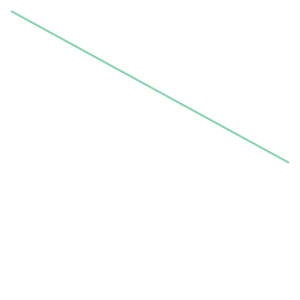

In [18]:
bLine = list(bLinePointMap.keys())[2]
print(bLine)
start_point = bLinePointCoords[bLine][0]
stop_point = bLinePointCoords[bLine][-1]
line = LineString([start_point,stop_point])
line

In [19]:
fpointsOnLine = {}
for xy in np.arange(0, fPointCoords.shape[0]):
    facePoint = Point(fPointCoords[xy])
    if line.intersects(facePoint.buffer(1)):
        fpointsOnLine[xy] = fPointCoords[xy]
        print(xy, facePoint)

20944 POINT (1325476.927353786 452621.5349359863)
20945 POINT (1325306.034583147 452714.8282309668)
20946 POINT (1325135.141812508 452808.1215259472)
20947 POINT (1324964.249041869 452901.4148209276)
20948 POINT (1324793.35627123 452994.708115908)


In [20]:
sortPoints = dict()
for fp, xy in fpointsOnLine.items():
    a = Point(start_point)
    b = Point(xy)
    distance_from_start =  a.distance(b)
    sortPoints[fp] = distance_from_start
    
sortedPoints = OrderedDict(sorted(sortPoints.items(), key=lambda x: x[1]))
sortedPoints

OrderedDict([(20944, 0.0),
             (20945, 194.69971223646547),
             (20946, 389.39942447290304),
             (20947, 584.0991367093405),
             (20948, 778.7988489457782)])

In [21]:
sortedPointList = list(sortedPoints.keys())
sortedPointList

[20944, 20945, 20946, 20947, 20948]

In [22]:
pointCombos = get_point_combos(sortedPointList)
pointCombos

[array([20944, 20945]),
 array([20945, 20946]),
 array([20946, 20947]),
 array([20947, 20948])]

In [23]:
searchTable = d17['data']
cells = []
faceCellCombos = {}

print('Face Points','\t', 'Face','\t', 'Common Cells', '\t','aCell (min el) bCell (min el)', '\tOrthogonal Dir')
for combo in pointCombos:
    aFaces = np.where(searchTable == combo[0])[0]
    bFaces = np.where(searchTable == combo[1])[0]
    commonFace = [f for f in aFaces if f in bFaces][0]
    
    faceCells = d16['data'][commonFace]
    for c in faceCells: cells.append(c)
    
    aCellMinElev = d4['data'][faceCells[0]]
    bCellMinElev = d4['data'][faceCells[1]]  
    
    
    # Read position info from d11
    startFind = d11['data'][combo[0]][0]
    stopFind = startFind+ d11['data'][combo[0]][1]
    startFind, stopFind 
    
    fPointFaces = d12['data'][startFind:stopFind]
    idx = np.argwhere(fPointFaces==commonFace)
    orthoDir = fPointFaces[idx[0][0]][-1]

    faceCellCombos[commonFace] = faceCells

    print(combo,'\t', commonFace, '\t',faceCells,'\t', aCellMinElev,'\t', bCellMinElev, '\t', orthoDir)

Face Points 	 Face 	 Common Cells 	 aCell (min el) bCell (min el) 	Orthogonal Dir
[20944 20945] 	 20306 	 [20393 20392] 	 9.6366625 	 8.368883 	 1
[20945 20946] 	 19522 	 [20396 20397] 	 0.0 	 0.10867936 	 -1
[20946 20947] 	 19506 	 [20398 20399] 	 0.0 	 0.0 	 -1
[20947 20948] 	 19492 	 [20401 20400] 	 2.312066 	 0.024748486 	 1


### Incomplete

Directionality: Figure out which cell is hiegher, assume downstream is the lower cells direction

In [24]:
crossCellPairs=[]
for combo in faceCellCombos:
    crossCells = str(faceCellCombos[combo][0]) +' '+ str(faceCellCombos[combo][1])
    crossCellPairs.append(crossCells)
crossCellPairs

['20393 20392', '20396 20397', '20398 20399', '20401 20400']

In [25]:
infoTable = {}
for c in cells:
    infoTable[c] = d1['data'][c]
    
infoTable

{20393: array([81996,     5]),
 20392: array([81991,     5]),
 20396: array([82010,     5]),
 20397: array([82015,     5]),
 20398: array([82020,     4]),
 20399: array([82024,     4]),
 20401: array([82033,     5]),
 20400: array([82028,     5])}

In [26]:
checkCells={}
for cell, vals in infoTable.items():
    startFind = infoTable[cell][0]
    stopFind = startFind + infoTable[cell][1]
    cFaces = d2['data'][startFind:stopFind]
    faces = [c[0] for c in cFaces]
    checkCells[cell] = faces
    print(cell, faces)

20393 [20304, 19525, 19485, 20305, 20306]
20392 [20324, 20691, 20308, 20306, 19521]
20396 [19505, 19519, 19520, 19521, 19522]
20397 [19484, 19480, 19523, 19522, 20305]
20398 [19503, 19504, 19505, 19506]
20399 [19506, 19523, 19479, 19493]
20401 [18704, 19491, 19492, 19493, 19478]
20400 [19498, 19503, 19492, 19507, 19508]


In [27]:
checkedCombos = {}
for i, c in enumerate(checkCells):
    for i2, c2 in enumerate(checkCells):
        combo = '{} {}'.format(c, c2)
        comboT= '{} {}'.format(c2, c)
        if (combo!=comboT) and (combo not in crossCellPairs) and (comboT not in crossCellPairs) and (combo not in checkedCombos) and (comboT not in checkedCombos):
            a = checkCells[c]
            b = checkCells[c2]
            NsharedFaces = len([f for f in a if f in b])
            if NsharedFaces !=0:
                checkedCombos[combo] = NsharedFaces
            print('Check {} against {}'.format(c,c2))
        
sharedPairs = [[x.split(' ')[0], x.split(' ')[1]] for x in list(checkedCombos.keys())]
sharedPairs

Check 20393 against 20396
Check 20393 against 20397
Check 20393 against 20398
Check 20393 against 20399
Check 20393 against 20401
Check 20393 against 20400
Check 20392 against 20396
Check 20392 against 20397
Check 20392 against 20398
Check 20392 against 20399
Check 20392 against 20401
Check 20392 against 20400
Check 20396 against 20393
Check 20396 against 20398
Check 20396 against 20399
Check 20396 against 20401
Check 20396 against 20400
Check 20397 against 20392
Check 20397 against 20398
Check 20397 against 20399
Check 20397 against 20401
Check 20397 against 20400
Check 20398 against 20393
Check 20398 against 20392
Check 20398 against 20397
Check 20398 against 20401
Check 20398 against 20400
Check 20399 against 20393
Check 20399 against 20392
Check 20399 against 20396
Check 20399 against 20401
Check 20399 against 20400
Check 20401 against 20393
Check 20401 against 20392
Check 20401 against 20396
Check 20401 against 20397
Check 20401 against 20398
Check 20400 against 20393
Check 20400 

[['20393', '20397'],
 ['20392', '20396'],
 ['20396', '20398'],
 ['20397', '20399'],
 ['20398', '20400'],
 ['20399', '20401']]

In [28]:
Group1, Group2 = get_groups(sharedPairs)
print(bLine)
print('Group 1 = ', Group1)
print('Group 2 = ', Group2)

Q02
Group 1 =  ['20399', '20397', '20401', '20393']
Group 2 =  ['20392', '20398', '20400', '20396']


In [29]:
cellFaces1={}
for g in Group1:
    cell = int(g)
    for face, cells in faceCellCombos.items():
        if cell in cells:
            cellFaces1[cell] = face


In [30]:
cellFaces2={}

for g in Group2:
    cell = int(g)
    for face, cells in faceCellCombos.items():
        if cell in cells:
            cellFaces2[cell] = face

In [31]:
print('{} Group 1\n\ncellFaceMap ='.format(bLine))
cellFaces1

Q02 Group 1

cellFaceMap =


{20399: 19506, 20397: 19522, 20401: 19492, 20393: 20306}

In [32]:
print('{} Group 2 \n\ncellFaceMap ='.format(bLine))
cellFaces2

Q02 Group 2 

cellFaceMap =


{20392: 20306, 20398: 19506, 20400: 19492, 20396: 19522}